<h1>TP Datos - Análisis exploratorio de datos</h1>
<p>El presente trabajo es un análisis exploratorio de datos basado en las publicaciones de venta de propiedades, publicadas en un lapso de 4 años, proporcionadas por la empresa <a href="http://www.properati.com.ar/">Properati</a></p>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import calendar
import math

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (5, 5)

<p>Aquí declaramos algunas funciones útiles que usaremos para poder realizar un chequeo de consistencia sobre el cálculo de los precios de las propiedades en venta.</p>

In [2]:
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. De lo contrario, nan (Not A Number)
def filter(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(surfaceTotal) or surfaceTotal == 0:
        return np.nan
    if not np.isnan(priceUSD) and not np.isnan(usdM2):
        price = usdM2 * surfaceTotal
        dif = abs(price - priceUSD)
        if ((dif / priceUSD) * 100) <= 10:
            return 1
    return 1

# Cálculo del precio aproximado de venta
def fillPrice(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(priceUSD) and not np.isnan(usdM2):
        return (usdM2 * surfaceTotal)
    return priceUSD

# Cálculo del precio del metro cuadrado
def fillM2(array):
    priceUSD, usdM2, surfaceTotal = array
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / surfaceTotal)
    return usdM2

In [ ]:
"""# Ruta de la carpeta con los archivos de datos originales
rutaCarpetaOriginales = "./properties/"

# Hacemos un rápido chequeo de los archivos, para saber si alguno se descargó mal
for archive in listdir(rutaCarpetaOriginales):
    if ".csv" in archive:
        nombreArchivo = rutaCarpetaOriginales + archive
        try:
            print nombreArchivo
            df = pd.read_csv(nombreArchivo, low_memory = False)
            print('Ok')
        except ValueError:
            print("Error, archivo corrupto. Descargar de nuevo")"""

In [ ]:
"""# Ruta de la carpeta con los archivos de datos modificados
root = "./properties/"
properties = []
indexAcum = 0
for archive in listdir(root):
    if ".csv" not in archive:
        continue
    df = pd.read_csv(root + archive, low_memory = False)
    df = df.loc[df.place_with_parent_names.str.contains('Capital Federal') | df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
    
    # Durante la carga de datos, se eliminan ciertas columnas que nos resultan irrelevantes para el trabajo,
    # como urls.
    if 'properati_url' in df:
        df.drop('properati_url', axis = 1, inplace = True)
    if 'geonames_id' in df:
        df.drop('geonames_id', axis = 1, inplace = True)
    if 'description' in df:
        df.drop('description', axis = 1, inplace = True)
    if 'image_thumbnail' in df:
        df.drop('image_thumbnail', axis = 1, inplace = True)
    if 'operation' in df:
        df.drop('operation', axis = 1, inplace = True)
    if 'created_on' in df:
        df.drop('created_on', axis = 1, inplace = True)
    if 'lat-lon' in df:
        df.drop('lat-lon', axis = 1, inplace = True)
    if 'currency' in df:
        df.drop('currency', axis = 1, inplace = True)
    if 'title' in df:
        df.drop('title', axis = 1, inplace = True)
    if 'id' in df:
        df.drop('id', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'price_aprox_usd' in df and 'price' in df:
        df.drop('price', axis = 1, inplace = True)
    if 'extra' in df and 'price' in df:
        df.drop('extra', axis = 1, inplace = True)

    # En algunos casos, es necesario renombrar algunas columnas
    if 'price_aprox_usd' not in df:
        df.rename(columns = {'price': 'price_aprox_usd'}, inplace = True)
    if 'surface_total_in_m2' not in df:
        df.rename(columns = {'surface_in_m2': 'surface_total_in_m2'}, inplace = True)

    # Aquí reconvertimos algunas columnas a punto flotante
    df.loc[:, 'price_aprox_usd'] = df.loc[:, ['price_aprox_usd']].apply(lambda x: float(x), axis = 1)
    df.loc[:, 'price_usd_per_m2'] = df.loc[:, ['price_usd_per_m2']].apply(lambda x: float(x), axis = 1)

    # obtenemos el año y mes del nombre de archivo
    date_splitted = archive.split('-')
    month = date_splitted[3]
    year = date_splitted[2]
    date = year + '-' + month
    size = len(df.index)
    dates = pd.Series([date for i in range(0, size)])
    # y lo ponemos como dato en una columna
    df['date'] = dates
    df.loc[:, ['date']] = pd.to_datetime(df['date'], errors = 'coerce')

    # Aquí aplicamos el filtro antes declarado
    df['filter'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(filter, axis = 1)
    df = df[~np.isnan(df['filter'])]
    df.loc[:, ['price_aprox_usd']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillPrice, axis = 1)
    df.loc[:, ['price_usd_per_m2']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillM2, axis = 1)
    df.drop('filter', axis = 1, inplace = True)

    # Finalmente, guardamos los archivos modificados.
    size = len(df.index)
    if size != 0:
        indexAcum += size
        newIndex = [i for i in range(indexAcum, indexAcum+size)]
        df.reindex(newIndex)
        print archive
        properties.append(df)
                 
#Genero un nuevo csvcon la concatenacion de todos ellos en uno solo
general = pd.concat(properties)

#Borro las columnas vacias
for column in general.columns.values:
    if 'Unnamed' not in column:
        continue
    general.drop(column, axis = 1, inplace = True)

general.loc[:, ['date']] = pd.to_datetime(general['date'], errors = 'coerce')

#Grabo la concatenacion en un unico csv
try:
    general.to_csv("propertiesConCat.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')
    print('Done')
except value:
    print('Error')"""

In [ ]:
"""# Aquí levantamos el archivo generado y reducimos su tamaño si es necesario
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

#Borramos la columna "extra"
df.drop('extra', axis = 1, inplace = True)
#Borramos la columna "unnamed: 0"
df.drop(df.columns.values[0], axis = 1, inplace = True)

#Volvemos a guardar los cambios en el archivo csv
df.to_csv("propertiesConCat.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')"""

In [3]:
#Abrimos el dataframe unificado
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

<p>Discretizamos cada DataFrame según pertenencia a Capital Federal</p>

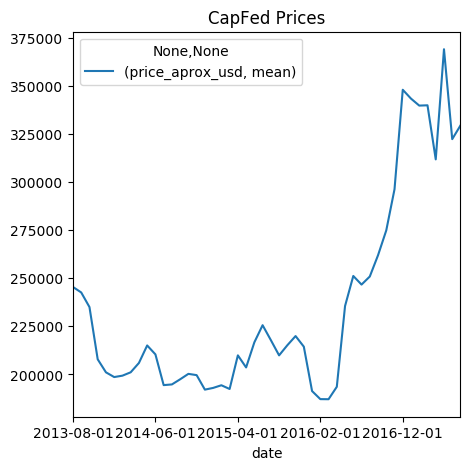

In [4]:
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF.loc[:, ['date', 'price_aprox_usd']].groupby('date').agg([np.mean, np.size]).reset_index()
CF.plot(x='date', y=('price_aprox_usd', 'mean') , kind='line', title="CapFed Prices")

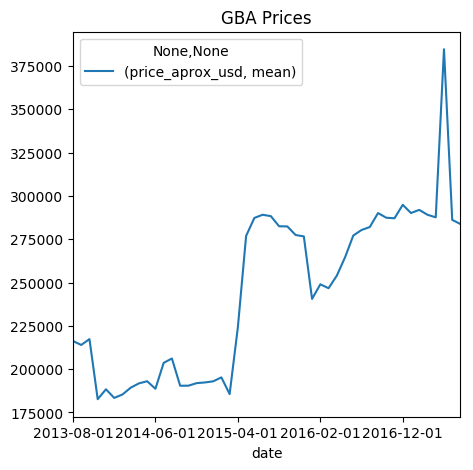

In [5]:
GBA = df.loc[df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
GBA = GBA.loc[:, ['price_aprox_usd', 'date']].groupby('date').agg([np.mean, np.size]).reset_index()
#date  = calendar.month_name[df['date'].dt.month.tolist()[0]] + '-' + str(df['date'].dt.year.tolist()[0])
GBA.plot(x='date', y=('price_aprox_usd', 'mean') , kind='line', title="GBA Prices")

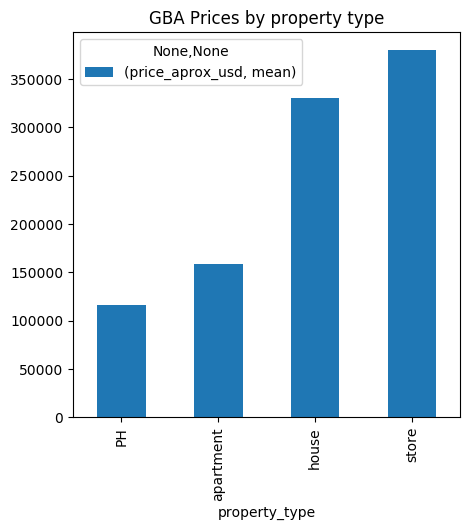

In [6]:
GBA = df.loc[df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
GBA = GBA.loc[:, ['property_type', 'price_aprox_usd']].groupby('property_type').agg([np.mean, np.size]).reset_index()
GBA.plot(x='property_type', y=('price_aprox_usd', 'mean') , kind='bar', title="GBA Prices by property type")

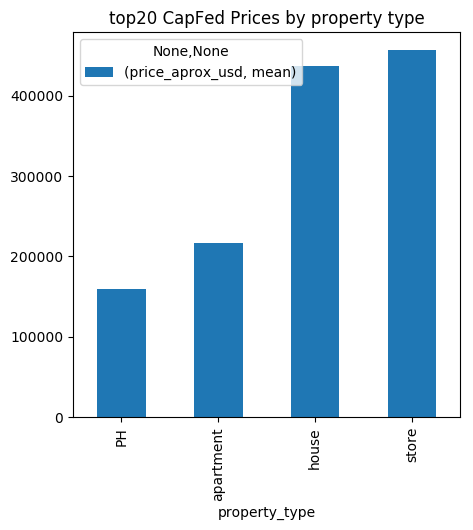

In [7]:
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF.loc[:, ['property_type', 'price_aprox_usd']].groupby('property_type').agg([np.mean, np.size]).reset_index()
CF.plot(x='property_type', y=('price_aprox_usd', 'mean') , kind='bar', title="top20 CapFed Prices by property type")

In [10]:
def ManhattanDistance(lat1, lon1, lat2, lon2):
    dlat = abs(lat1-lat2) * (10000/90) # pasamos la diferencia a metros (90° son 10000 Km)
    dlon = abs(lon1-lon2) * (40000/360) # pasamos la diferencia a metros (360° son 40000 Km)
    distKM = ( (dlat ** 2) + (dlon ** 2) ) ** (0.5)
    return float(distKM * 1000)
    """dlat = abs(lat1-lat2)
    dlon = abs(lon1-lon2)
    a = ((math.sin(dlat/2)) ** 2) + math.cos(lat1) * math.cos(lat2) * ((math.sin(dlon/2)) **2 )
    y = a ** (0.5)
    x = (1-a) ** (0.5)
    c = 2 * math.atan2(y, x)
    R = 6371 # Radio de la tierra en Km
    return R * c"""

In [27]:
subways = pd.read_csv('./extra/estaciones-de-subte.csv', low_memory=False)
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF[~np.isnan(CF['lon']) | ~np.isnan(CF['lat'])]
CF = CF[CF['place_name'] != "Capital Federal"]
lat = CF['lat'].tolist()
lon = CF['lon'].tolist()
x = subways['X'].tolist()
y = subways['Y'].tolist()
distances = []
minor = 0;
for i in range(0, len(lat)):
    minor = ManhattanDistance(y[0], x[0], lat[i], lon[i])
    for j in range(1, len(x)):
        dist = ManhattanDistance(y[j], x[j], lat[i], lon[i])
        if (dist < minor):
            minor = dist
    distances.append(minor)
CF['distances'] = pd.Series(distances)
CF = CF.loc[:, ['distances', 'price_aprox_usd']].groupby('distances').agg([np.mean, np.size]).reset_index()
CF = CF[~np.isnan(CF[('price_aprox_usd', 'mean')])]
CF = CF[CF[('price_aprox_usd', 'mean')] > 0]

# Grafico De la densidad de la variacion del precio en funcion de la cercania a una parada de subte

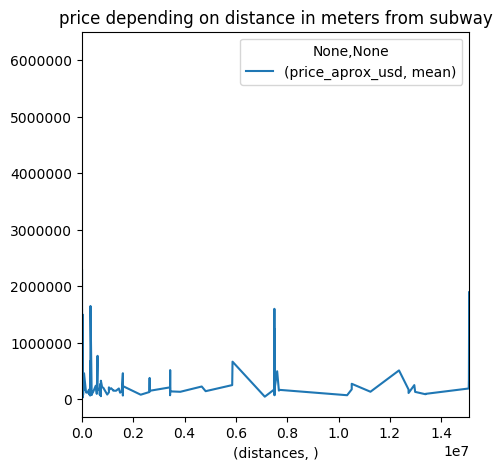

In [35]:
#CF = CF.sort_values(by='distances', ascending=False)
#CF = CF.loc[:, ['distances', ('price_aprox_usd', 'mean')]].groupby(('price_aprox_usd', 'mean')).agg([np.mean, np.size]).reset_index()

# Filtro Las distancias lejanas porque si no la escala no se ve favorecida para graficarlos puntos calculados
CF = CF[CF[('distances', '')] < 10**9]

CF.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', title="price depending on distance in meters from subway")

In [14]:
hospitals = pd.read_csv("./extra/hospitales.csv", low_memory=False, sep=';', error_bad_lines=False)
BsAs = df[~np.isnan(df['lon']) | ~np.isnan(df['lat'])]
lat = BsAs['lat'].tolist()
lon = BsAs['lon'].tolist()
x = hospitals['LNG'].tolist()
y = hospitals['LAT'].tolist()
distances = []
minor = 0;
for i in range(0, len(lat)):
    minor = ManhattanDistance(y[0], x[0], lat[i], lon[i])
    for j in range(1, len(x)):
        dist = ManhattanDistance(y[j], x[j], lat[i], lon[i])
        if (dist < minor):
            minor = dist
    distances.append(minor)
BsAs['distances'] = pd.Series(distances)
BsAs = BsAs[~np.isnan(BsAs['distances'])]
BsAs = BsAs.loc[:, ['distances', 'price_aprox_usd']].groupby('distances').agg([np.mean, np.size]).reset_index()

/home/sebastian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# Grafico De la densidad de la variacion del precio en funcion de la cercania a un hospital

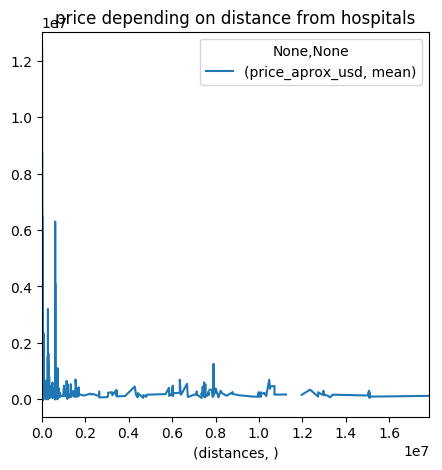

In [39]:
# Filtro Las distancias lejanas porque si no la escala no se ve favorecida para graficarlos puntos calculados
BsAs = BsAs[BsAs[('distances', '')] < 10**9]

BsAs.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', title="price depending on distance from hospitals")

In [40]:
def changeStringCommaForPoint(string):
    point = "."
    split = string.split(',')
    return point.join(split)
def changeStringListCommaForPoint(stringList):
    aux = []
    for string in stringList:
        aux.append(changeStringCommaForPoint(string))
    return aux

In [17]:
busStops = pd.read_csv("./extra/paradas-de-colectivo.csv", low_memory=False, sep=';', error_bad_lines=False)
busStops['X'] = pd.Series(changeStringListCommaForPoint(busStops['X'].tolist()))
busStops['Y'] = pd.Series(changeStringListCommaForPoint(busStops['Y'].tolist()))
busStops.loc[:, 'X'] = busStops.loc[:, ['X']].apply(lambda x: float(x), axis = 1)
busStops.loc[:, 'Y'] = busStops.loc[:, ['Y']].apply(lambda x: float(x), axis = 1)
busStops = busStops[~np.isnan(busStops['X']) | ~np.isnan(busStops['Y'])]

CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF.loc[:, ['lon', 'lat', 'price_aprox_usd', 'place_name']].groupby('place_name').agg([np.mean, np.size]).reset_index()
CF = CF[~np.isnan(CF['lon', 'mean']) | ~np.isnan(CF[('lat', 'mean')])]
#CF = CF[CF[('price_aprox_usd', 'size')] > 200]

lat = CF[('lat', 'mean')].tolist()
lon = CF[('lon', 'mean')].tolist()
x = busStops['X'].tolist()
y = busStops['Y'].tolist()

distances = []
minor = 0;

for i in range(0, len(lat)):
    minor = ManhattanDistance(y[0], x[0], lat[i], lon[i])
    for j in range(1, len(x)):
        dist = ManhattanDistance(y[j], x[j], lat[i], lon[i])
        if (dist < minor):
            minor = dist
    distances.append(minor)

CF['distances'] = pd.Series(distances)
CF = CF.loc[:, [('price_aprox_usd', 'mean'), ('distances', '')]].groupby('distances').mean().reset_index()
CF = CF.sort_values(by=('distances', ''), ascending=True)

# Grafico De la densidad de la variacion del precio en funcion de la cercania a una parada de subte

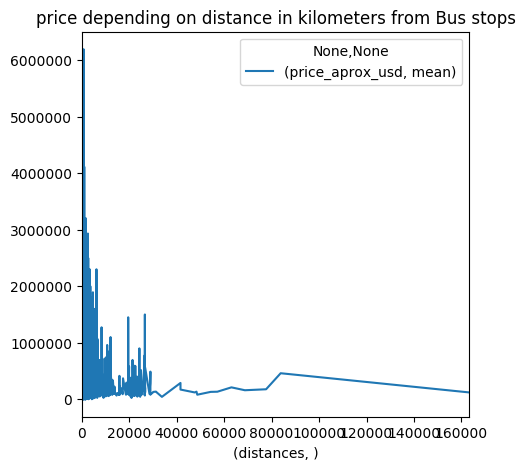

In [43]:
CF = CF[CF[('distances', '')] < 200000]
CF.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', title="price depending on distance in kilometers from Bus stops")

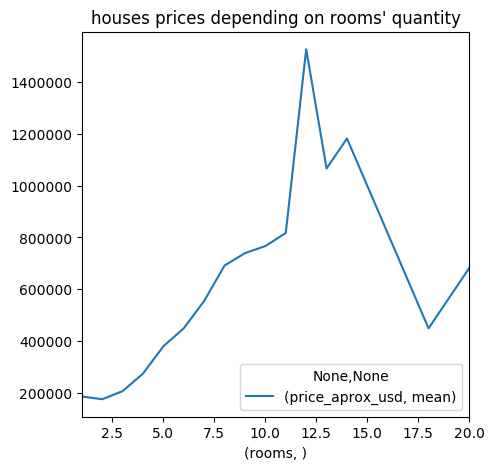

In [19]:
houses = df[df['property_type'] == 'house']
houses = houses[~np.isnan(houses['rooms'])]
houses = houses[houses['rooms'] != 0]
houses = houses.loc[:, ['rooms', 'price_aprox_usd']].groupby('rooms').agg([np.mean, np.size]).reset_index()
houses = houses[houses[('price_aprox_usd', 'size')] >= 10]
#houses
houses.plot(x=('rooms', ''), y=('price_aprox_usd', 'mean') , kind='line', title="houses prices depending on rooms' quantity")